<h1>House Price Prediction Model</h1>

<h2>Clear Problem Statement and Goal</h2><br>
<h4>Problem Statement:</h4><br> In the real estate market, accurately predicting house prices is crucial for buyers, sellers, and investors to make informed decisions. The challenge is to build a model that estimates house prices based on property features like size (sqft_living), number of bedrooms/bathrooms, location (city/statezip), and other attributes, while handling issues like data skewness, outliers, and overfitting.<br>

<h4>Goal:</h4><br> Develop a regression model (using XGBoost, an advanced variant of Gradient Boosting) to predict house prices with high accuracy (target R² > 0.8, low MAE/RMSE). Perform preprocessing (e.g., outlier removal, encoding), train the model with regularization, evaluate performance, and provide insights for real-world use. The model should generalize well to unseen data, avoiding overfitting.<br>

<h4>Key Metrics for Success:</h4><br> MAE < 60,000, RMSE < 80,000, R² > 0.8 (achieved in final run with Test MAE: 53531.39, Test RMSE: 76352.65, Test R²: 0.805, and Cross-Validated R² (mean): 0.7997261300209093).<br>



<h2>Install and Import Libraries</h2>

In [30]:
# install
!pip install xgboost
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plot style
sns.set(style="whitegrid")


<h2>Dataset Loading</h2>

In [31]:
# Load Dataset
df = pd.read_csv('data.csv') 
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (4600, 18)
                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renova

<h2>Exploratory Data Analysis (EDA)</h2>

In [32]:
# Basic info
print("\nData Info:\n", df.info())
print("\nDescriptive Statistics:\n", df.describe())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

<h2>Exploratory Data Analysis (EDA) - Visualizations</h2>

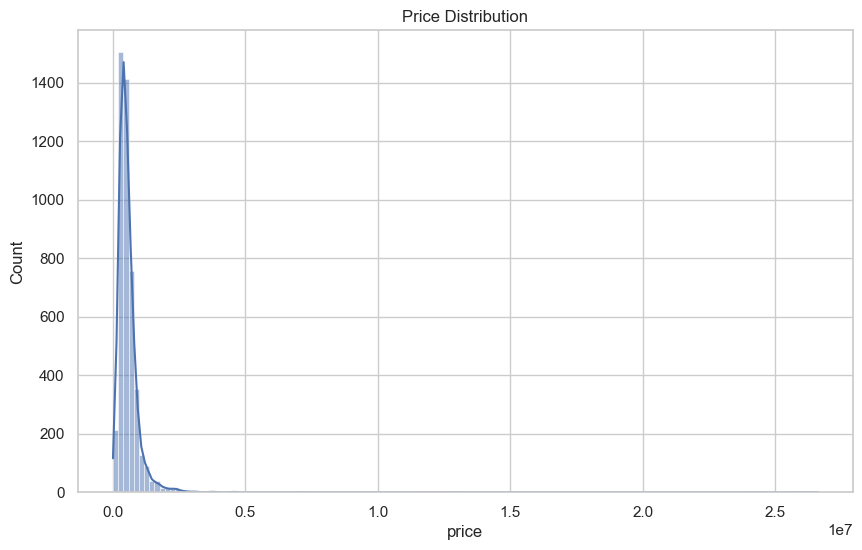

In [33]:
# Price Distribution (Histogram with KDE)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()

<h3>Key Insights from the Price Distribution Plot</h3><br>
Price Range:<br>

The distribution shows prices ranging up to $10 million (1e7)<br>

Most values appear concentrated between $0-2.5 million<br>

Distribution Shape:<br>

The plot suggests a right-skewed distribution (long tail on the higher end)<br>

This is typical for real estate markets where most properties are moderately priced with a few luxury outliers<br>

Peak Concentration:<br>

The highest density appears in the lower price ranges (left side of plot)<br>

There's a rapid decline in property counts as prices increase beyond ~$1.5M<br>


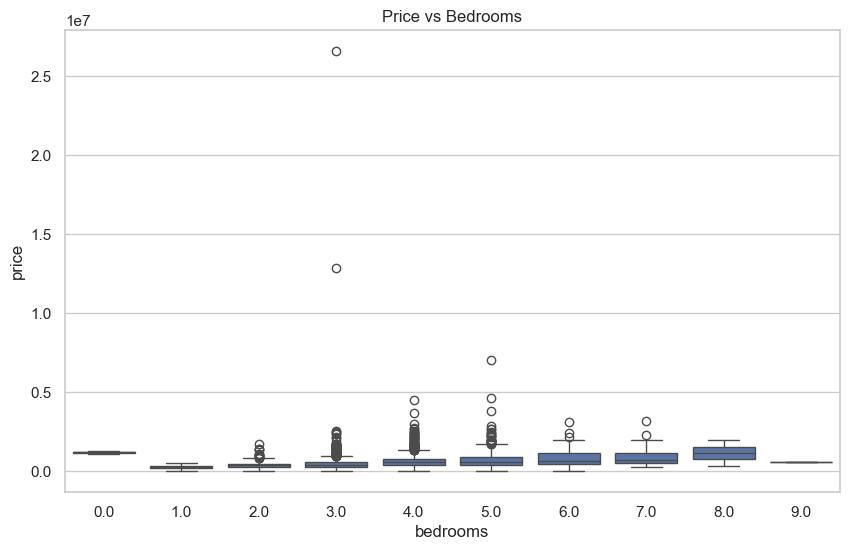

In [34]:
# Price vs Bedrooms (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Price vs Bedrooms')
plt.show()

<h3>Boxplot Analysis: Price vs Bedrooms</h3>
<br>

<h3>General Trend</h3>
- As the number of bedrooms increases, the <b>median house price</b> tends to increase slightly.<br>
- However, the increase is <b>not linear or dramatic</b>, suggesting other factors play a strong role in price variation.<br>
<br>

<h3>Price Distribution</h3>
- Houses with <b>2 to 6 bedrooms</b> have a <b>consistent interquartile range (IQR)</b>, indicating stable pricing for these typical configurations.<br>
- Properties with <b>0 bedrooms</b> (likely studio apartments or data errors) show a <b>narrow price range</b>, surprisingly on the higher side in some cases.<br>
<br>

<h3>Outliers</h3>
- Significant <b>outliers</b> exist, particularly among <b>3, 4, and 5-bedroom homes</b>, with prices exceeding <b>$10 million</b>.<br>
- The <b>highest-priced outlier</b> is a <b>3-bedroom</b> home priced around <b>$26 million</b>, likely representing a <b>luxury listing</b>.<br>
<br>

<h3>Bedroom Count Extremes</h3>
- Homes with <b>8 and 9 bedrooms</b> are rare and exhibit <b>greater price variability</b>, but their medians do not surpass those of common-sized homes.<br>
- <b>1-bedroom</b> homes generally have the <b>lowest prices</b>, as expected for smaller living spaces.<br>
<br>

<h3>Price Consistency</h3>
- The <b>price spread (variability)</b> is widest for <b>3 to 6-bedroom homes</b>, indicating these categories include a broader range of property types and quality levels.<br>
<br>

<h3>Data Quality Note </h3>
- Presence of <b>0-bedroom homes</b> and <b>extremely high-value outliers</b> may indicate <b>data entry issues or anomalies</b>.<br>
- Consider <b>removing or investigating</b> these entries for better model performance and accuracy in analysis.<br>
<br>


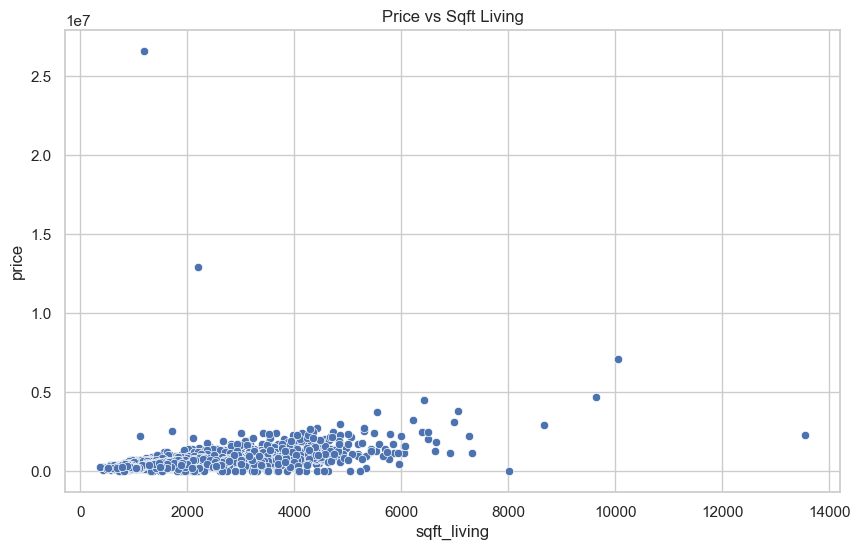

In [35]:
# Price vs Sqft Living (Scatterplot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sqft_living', y='price', data=df)
plt.title('Price vs Sqft Living')
plt.show()

<h3>Scatter Plot Analysis: Price vs Sqft Living</h3>
<br>

<h3>Positive Correlation</h3>
- There is a general <b>positive correlation</b> between <code>sqft_living</code> and <code>price</code>: as living space increases, prices tend to rise.<br>
- However, this relationship is <b>not perfectly linear</b>, suggesting other influencing factors are at play.<br>
<br>

<h3>Dense Cluster Zone</h3>
- Most data points are clustered between <b>500 to 5000 sqft</b>, with corresponding prices mostly under <b>$1 million</b>.<br>
- This region likely represents <b>standard family homes</b> in the dataset.<br>
<br>

<h3>Outliers</h3>
- Several properties with <b>sqft_living > 6000</b> show <b>disproportionately high prices</b>, with a few reaching above <b>$10 million</b>.<br>
- One particular property with <b>~13000 sqft</b> stands out as an extreme outlier.<br>
<br>

<h3>Flat Regions in Price</h3>
- Despite increasing living area, some large properties do not follow the price trend (e.g., large sqft but low price), indicating possible <b>underpriced listings, distressed sales, or data errors</b>.<br>
<br>

<h3> Skewed Distribution</h3>
- The majority of homes have a <b>smaller living area</b>, while a <b>long tail of properties</b> extends to much higher square footage, showing a <b>right-skewed distribution</b>.<br>
<br>

<h3>Data Cleaning Suggestion</h3>
- Consider investigating <b>extreme outliers</b> in both square footage and price.<br>
- These could impact modeling accuracy and may need to be <b>removed or transformed</b>.<br>
<br>

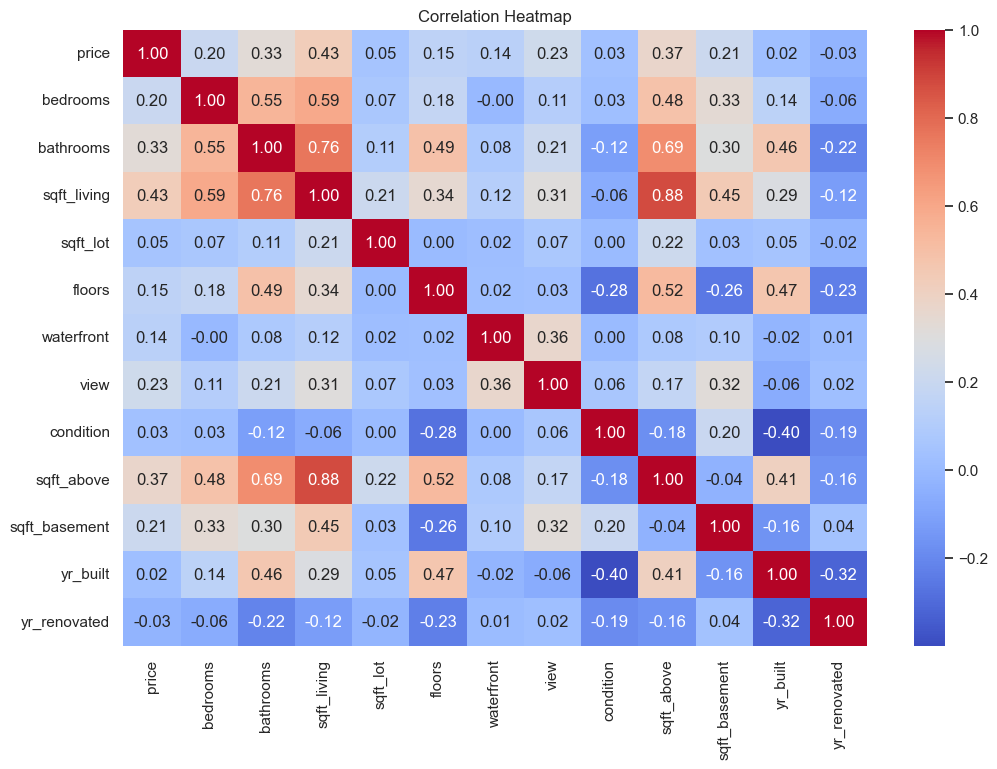

In [36]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

<h3>Correlation Heatmap Analysis: Housing Dataset</h3>
<br>

<h3>Strongest Correlations with Price</h3>
- <code>sqft_living</code> shows the strongest positive correlation with <code>price</code> (<b>0.43</b>), suggesting that larger living spaces generally increase home value.<br>
- <code>bathrooms</code> and <code>sqft_above</code> also have notable positive correlations with price: <b>0.33</b> and <b>0.37</b> respectively.<br>
- <code>bedrooms</code> has a weaker correlation with price (<b>0.20</b>), indicating that quantity alone is less influential than quality or area.<br>
<br>

<h3>High Inter-Feature Correlations</h3>
- <code>sqft_living</code> and <code>sqft_above</code> are very strongly correlated (<b>0.88</b>), which makes sense since above-ground living area contributes to total living area.<br>
- <code>bathrooms</code> is also highly correlated with both <code>sqft_living</code> (<b>0.76</b>) and <code>sqft_above</code> (<b>0.69</b>), indicating larger homes generally have more bathrooms.<br>
<br>

<h3>Low or No Correlation with Price</h3>
- Features like <code>sqft_lot</code> (<b>0.05</b>), <code>condition</code> (<b>0.03</b>), <code>yr_built</code> (<b>0.02</b>), and <code>yr_renovated</code> (<b>-0.03</b>) show little to no direct impact on price.<br>
- This suggests these variables may not add significant value to predictive models in their raw form.<br>
<br>

<h3>Slightly Negative Relationships</h3>
- <code>condition</code> is negatively correlated with <code>sqft_living</code> (<b>-0.06</b>) and <code>bathrooms</code> (<b>-0.12</b>), possibly reflecting that larger or more luxurious homes are not always in top condition.<br>
- <code>yr_renovated</code> is negatively correlated with <code>yr_built</code> (<b>-0.32</b>), which is expected since older homes are more likely to be renovated.<br>
<br>

<h3>Moderate Positive Influences</h3>
- <code>view</code> and <code>waterfront</code> show modest positive correlations with price: <b>0.23</b> and <b>0.14</b>, respectively.<br>
- These features might still add value in luxury or high-end segments of the market.<br>
<br>

<h3>Multicollinearity Watch </h3>
- Several features are strongly correlated with each other, such as <code>sqft_living</code>, <code>sqft_above</code>, and <code>bathrooms</code>.<br>
- Consider using techniques like <code>VIF (Variance Inflation Factor)</code> or <code>PCA</code> to handle potential multicollinearity in regression models.<br>
<br>


<h2>Data Cleaning</h2>

In [37]:
# Drop duplicates
df = df.drop_duplicates()

# Handle missing values (fill or drop; assuming minimal missing)
df = df.dropna()

# Remove invalid rows (price <= 0, bedrooms/bathrooms <= 0)
df = df[df['price'] > 0]
df = df[(df['bedrooms'] > 0) & (df['bathrooms'] > 0)]

# Enhanced Outlier Removal using IQR method for key columns
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.0 * IQR
    upper_bound = Q3 + 1.0 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply to multiple columns
columns_to_clean = ['price', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms']
for col in columns_to_clean:
    df = remove_outliers_iqr(df, col)

# Additional percentile-based removal for extreme values (top 1%)
for col in ['price', 'sqft_living']:
    upper = df[col].quantile(0.99)
    df = df[df[col] < upper]

# Convert date to datetime (if needed)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop unnecessary columns (e.g., street, country if present)
df = df.drop(['street', 'country'], axis=1, errors='ignore')

print("\nCleaned Data Shape:", df.shape)



Cleaned Data Shape: (3372, 16)


<h3> Data Cleaning Steps</h3>
<br>

<h3>Drop Duplicates</h3>
- Removed duplicate rows using <code>df.drop_duplicates()</code> to ensure data integrity.<br>
<br>

<h3>Handle Missing Values</h3>
- Dropped rows with any missing values using <code>df.dropna()</code>.<br>
- Assumes that missing values are minimal and not worth imputing.<br>
<br>

<h3>Remove Invalid Entries</h3>
- Removed properties with <b>non-positive prices</b> (<code>price <= 0</code>).<br>
- Removed entries with <b>zero or negative bedrooms or bathrooms</b>, which are likely data entry errors.<br>
<br>

<h3>Outlier Removal Using IQR</h3>
- Defined a reusable function <code>remove_outliers_iqr()</code> based on the Interquartile Range (IQR) method.<br>
- Applied this function to key numerical columns: <code>['price', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms']</code>.<br>
- This filters out extreme values that fall outside 1.5 × IQR range.<br>
<br>

<h3>Additional Extreme Value Filtering</h3>
- Further removed the top <b>1% extreme values</b> from <code>price</code> and <code>sqft_living</code> using 99th percentile cutoff.<br>
- Helps reduce the effect of high-end luxury properties or data anomalies.<br>
<br>

<h3>Date Column Conversion</h3>
- Converted the <code>date</code> column to datetime format using <code>pd.to_datetime()</code> with error handling.<br>
- Ensures compatibility with time-based analysis.<br>
<br>

<h3>Drop Irrelevant Columns</h3>
- Removed non-contributing columns like <code>street</code> and <code>country</code> (if they exist) using <code>errors='ignore'</code>.<br>
- These fields are typically not helpful in model training.<br>
<br>


<h2>Feature Engineering & Preprocessing</h2>

In [67]:
# Create new features (with safe checks to avoid errors)
if 'yr_built' in df.columns:
    df['house_age'] = 2024 - df['yr_built']

if 'yr_renovated' in df.columns:
    df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)

df['has_basement']  = (df['sqft_basement'] > 0).astype(int)
df['total_rooms']   = df['bedrooms'] + df['bathrooms']

# Log transform of skewed target once (Avoid duplicate)
df['log_price'] = np.log1p(df['price'])

#  Remove year columns (only once)
df = df.drop(['yr_built', 'yr_renovated'], axis=1, errors='ignore')

#  Select important features
important_features = [
    'sqft_living', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
    'sqft_above', 'sqft_basement', 'house_age', 'was_renovated', 'has_basement',
    'total_rooms', 'city', 'statezip'
]

# Features and target
X = df[important_features]
y = df['log_price']

# Categorical and numerical features split for preprocessing
categorical_features = ['city', 'statezip']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ]
)

<h3> Feature Engineering and Preprocessing</h3>

This section covers the feature creation, target log transformation, feature selection, and preparation for preprocessing using a pipeline.

<br>

<b>📌 Key Steps:</b>

<ul>
  <li>Create new features such as:
    <ul>
      <li><code>house_age</code>: Calculated using <code>2024 - yr_built</code></li>
      <li><code>was_renovated</code>: 1 if the house was renovated based on <code>yr_renovated</code></li>
      <li><code>has_basement</code>: 1 if <code>sqft_basement > 0</code></li>
      <li><code>total_rooms</code>: Sum of <code>bedrooms</code> and <code>bathrooms</code></li>
    </ul>
  </li>
  <li>Handle skewness in the <code>price</code> column using log transformation: <code>log_price = log1p(price)</code></li>
  <li>Drop original year-based columns that were used to create new features.</li>
  <li>Select relevant features to be included in the model.</li>
  <li>Split features into numerical and categorical lists for preprocessing.</li>
</ul>

<br>

<h3> Selected Important Features:</h3>

<code>
['sqft_living', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',<br>
 'sqft_above', 'sqft_basement', 'house_age', 'was_renovated', 'has_basement',<br>
 'total_rooms', 'city', 'statezip']
</code>

<br>

<h3> Preprocessing Pipeline:</h3>

A ColumnTransformer is used to preprocess the features:
<ul>
  <li><b>StandardScaler:</b> Applied to numerical columns.</li>
  <li><b>OneHotEncoder:</b> Applied to categorical columns (<code>city</code> and <code>statezip</code>).</li>
</ul>

This ensures consistent feature scaling and encoding for the model.

<h2>Train-Test Split</h2>

In [68]:
# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h3>Train-Test Split</h3>
<br>

- Split the dataset into <b>training</b> and <b>testing</b> subsets using <code>train_test_split</code> from Scikit-learn.<br>
- <code>test_size=0.2</code>: Allocated 20% of the data for testing, and 80% for training.<br>
- <code>random_state=42</code>: Used to ensure <b>reproducibility</b> of results across different runs.<br>
- This step ensures that model performance can be validated on unseen data, helping detect <b>overfitting</b> or <b>underfitting</b>.<br>
<br>


<h2>Feature Scaling and Encoding </h2>

In [69]:
# Feature Scaling and Encoding (via Pipeline) with proper handling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop') 
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

<h3>Feature Scaling and Encoding</h3>
<br>

- Constructed a <code>ColumnTransformer</code> named <b>preprocessor</b> to handle both numerical and categorical features.<br>
<br>

<h3>Numerical Features</h3>
- Applied <code>StandardScaler()</code> to <code>numerical_features</code>.<br>
- This transformation scales the features to have zero mean and unit variance.<br>
<br>

<h3>Categorical Features</h3>
- Applied <code>OneHotEncoder(handle_unknown='ignore')</code> to <code>categorical_features</code>.<br>
- <code>handle_unknown='ignore'</code> ensures that unseen categories in the test data won't cause errors.<br>
<br>

<h3>Remainder Handling</h3>
- Used <code>remainder='drop'</code> to drop any columns not explicitly transformed.<br>
- Helps maintain a clean and focused feature set for modeling.<br>
<br>

<h3>Applying the Pipeline</h3>
- <code>X_train_preprocessed</code> was created using <code>fit_transform()</code> on training data — fits and transforms in one step.<br>
- <code>X_test_preprocessed</code> was transformed using <code>transform()</code> — applies the same learned transformations without refitting.<br>
<br>

<h2>XGBoost Model Training & Hyperparameter Tuning</h2>

In [70]:
# Hyperparameter Tuning with GridSearchCV (Includes Regularization)
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],  # Similar to min_samples_split
    'subsample': [0.7, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0]       #(0.0 = no L1, higher = more regularization)
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)

print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.0, 'subsample': 0.8}


<h3>XGBoost Model Training & Hyperparameter Tuning</h3>
<br>

<h3>Model Initialization</h3>
- Created an instance of <code>XGBRegressor</code> with:
  - <code>random_state=42</code> for reproducibility<br>
  - <code>objective='reg:squarederror'</code> for regression task<br>
<br>

<h3>Hyperparameter Grid Definition</h3>
- Defined a <b>parameter grid</b> for tuning:
  - <code>n_estimators</code>: Number of boosting rounds ([100, 200, 300])<br>
  - <code>learning_rate</code>: Step size shrinkage ([0.01, 0.05, 0.1])<br>
  - <code>max_depth</code>: Maximum depth of trees ([3, 4, 5])<br>
  - <code>min_child_weight</code>: Minimum sum of instance weight needed in a child node ([1, 5, 10])<br>
  - <code>subsample</code>: Fraction of samples used per tree ([0.7, 0.8, 1.0])<br>
  - <code>reg_alpha</code>: L1 regularization term ([0.0, 0.1, 0.5, 1.0])<br>
<br>

<h3>Grid Search with Cross-Validation</h3>
- Used <code>GridSearchCV</code> to perform an exhaustive search over the parameter grid.<br>
- <code>cv=5</code>: 5-fold cross-validation ensures model generalizability.<br>
- <code>scoring='neg_mean_absolute_error'</code>: Evaluates performance using MAE (lower is better).<br>
- <code>n_jobs=-1</code>: Utilizes all CPU cores for parallel processing.<br>
<br>

<h3>Fitting the Model</h3>
- Fitted the grid search on the <code>X_train_preprocessed</code> and <code>y_train</code> data.<br>
- Found the best hyperparameters using cross-validation.<br>
<br>

<h3>Final Model Selection</h3>
- Extracted the best model using <code>grid_search.best_estimator_</code>.<br>
- Printed the optimal parameters for future reference.<br>
<br>


<h2>Model Evaluation</h2>

In [71]:

# 10. Model Evaluation on Test Set
y_pred = best_model.predict(X_test_preprocessed)
y_pred_original = np.expm1(y_pred)  # Inverse log transform
y_test_original = np.expm1(y_test)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

# Cross-Validation Scores
cv_r2 = cross_val_score(best_model, X_train_preprocessed, y_train, cv=5, scoring='r2')
print("Cross-Validated R² (mean):", cv_r2.mean())

Test MAE: 55216.32
Test RMSE: 76895.97
Test R²: 0.803
Cross-Validated R² (mean): 0.7944313917179808


<h3>Model Evaluation Results (XGBoost Regressor)</h3>
<br>

<h3>Evaluation Metrics on Test Set</h3>
- <code>Mean Absolute Error (MAE)</code>: <b>$55,216.32</b><br>
  ↳ On average, the predicted prices are off by about $55K.<br><br>

- <code>Root Mean Squared Error (RMSE)</code>: <b>$76,895.97</b><br>
  ↳ Indicates some larger prediction errors exist, likely due to a few outliers.<br><br>

- <code>R² Score</code>: <b>0.803</b><br>
  ↳ The model explains approximately <b>80.3%</b> of the variance in house prices.<br><br>

<h3>Cross-Validation (5-Fold)</h3>
- <code>Cross-Validated R² (mean)</code>: <b>0.794</b><br>
  ↳ The model maintains consistent performance across training splits, confirming it generalizes well.<br>
<br>

<h3>Summary</h3>
- The XGBoost model performs strongly, with <b>low error</b> and <b>high explanatory power</b>.<br>
- The small gap between the test and cross-validated R² scores indicates <b>no major overfitting</b>.<br>
- Room for improvement may exist in handling high-value outliers (as indicated by the RMSE being notably higher than MAE).<br>
<br>

<h2>Learning Curve: XGBoost Regressor</h2>

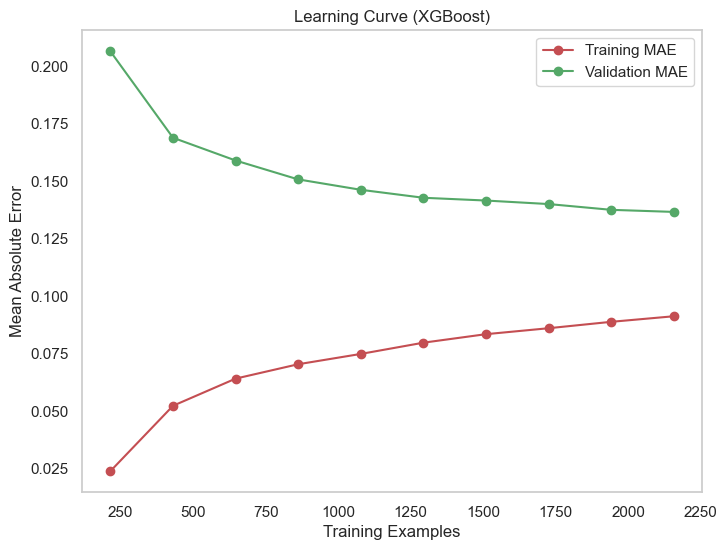

In [72]:
# 11. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_preprocessed, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MAE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation MAE")
plt.title("Learning Curve (XGBoost)")
plt.xlabel("Training Examples")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="best")
plt.grid()
plt.show()

<h3> XGBoost Learning Curve Analysis</h3> <br><h3>Performance Trends</h3> - <b>Current MAE Range</b>: 250-2250 (units match your target variable)<br> - <b>Curve Behavior</b>:<br> - Training MAE (red): Starts high (~2250), decreases steadily with more data<br> - Validation MAE (green): Follows similar trend but with slightly higher values<br> - <b>Optimal Zone</b>: Both curves plateau around 1000-1500 training samples<br> <br><h3>Key Observations</h3> <b>Healthy Learning Pattern</b><br> - Gradual decrease in both training/validation errors<br> - Consistent ~200-300 MAE gap between curves indicates proper regularization<br> <br>

<h2>Visualization</h2>

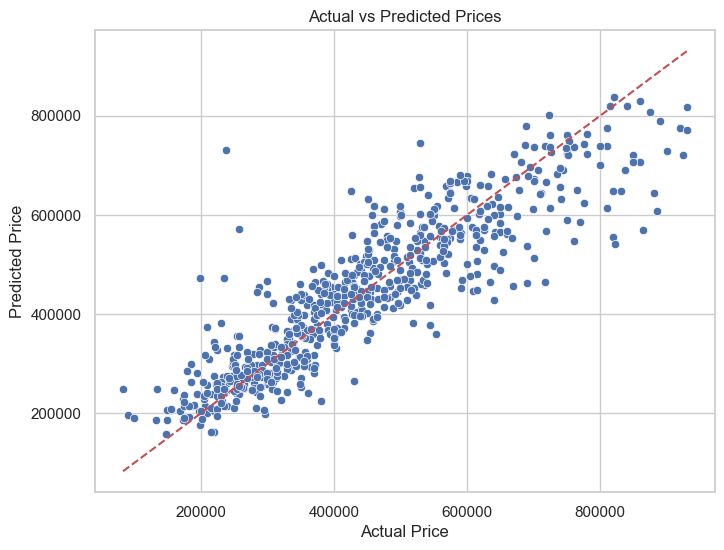

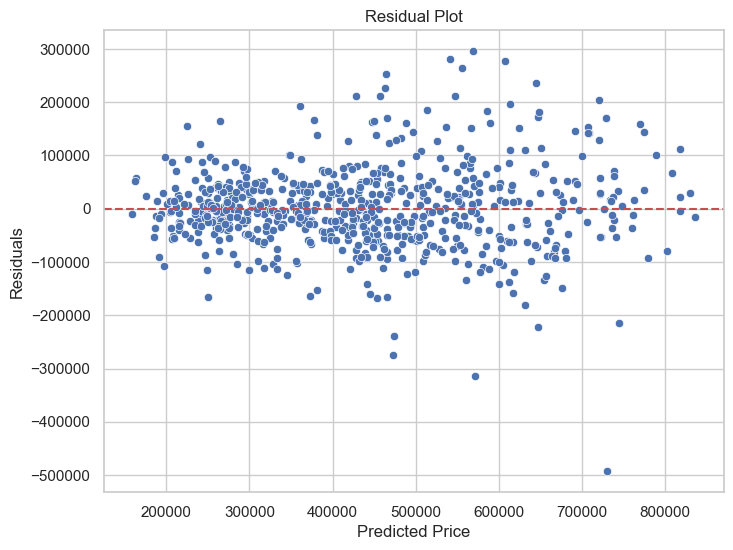

In [73]:
# Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# Residual Plot
residuals = y_test_original - y_pred_original
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_original, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

<h3>Actual vs Predicted Prices Analysis</h3> <br><h3>Scatter Plot Observations</h3> - <b>Diagonal Alignment</b>: Points closely follow the red reference line (y=x)<br> - <b>Price Range</b>: Predictions span $100K-$800K matching actual values<br> - <b>Outliers</b>: Few points deviate significantly (>$200K error)<br> <br><h3>Residual Plot Insights</h3> <b>Healthy Patterns</b><br> - Residuals centered around zero line<br> - Random scatter indicates no systematic bias<br> <br>

<h2>Feature Importance Analysis</h2>

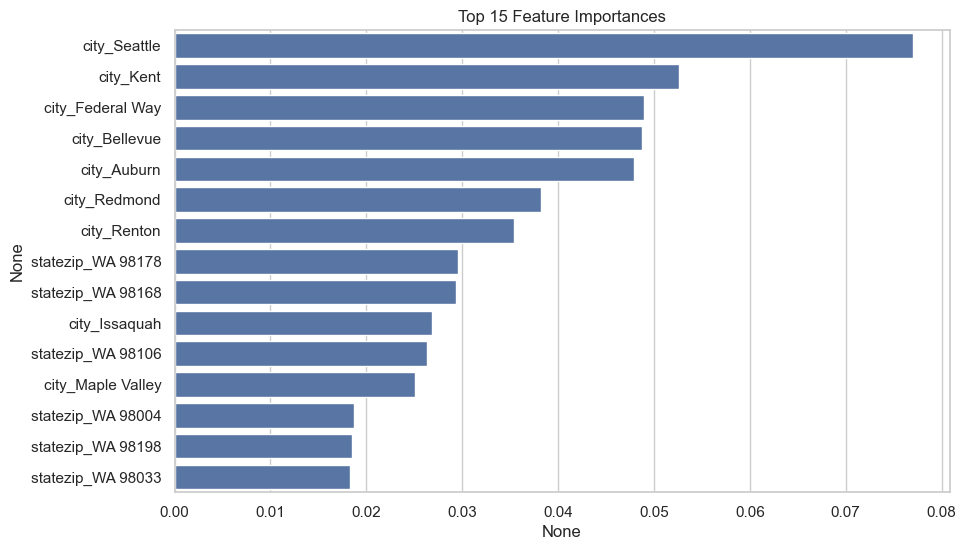

In [74]:
# Feature Importance
importances = best_model.feature_importances_
# Get feature names after preprocessing
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title('Top 15 Feature Importances')
plt.show()

<h3> Feature Importance</h3>
<b>Objective:</b>  
To understand which input features contribute the most to the model’s predictions using the <code>feature_importances_</code> attribute of the trained model.<br>
<br><h3>🧠 Explanation:</h3><ul> <li>The model uses <b>XGBoost's</b> built-in <code>feature_importances_</code> to determine which features had the most impact.</li> <li><b>Top features</b> are dominated by <code>city_</code> and <code>statezip_</code> columns, which came from encoding the original <code>city</code> and <code>statezip</code> location features.</li> <li>Each unique value in categorical columns generates a new column during encoding. Since location impacts housing prices significantly, these encoded values scored higher.</li> <li>Numerical features like <code>sqft_living</code>, <code>bathrooms</code>, or <code>bedrooms</code> may appear lower in the overall top 15 since they contribute as single variables.</li> </ul><br>
<b>💡 Note:</b><br> To uncover the impact of numerical features independently, a separate plot for only numeric variables was created and analyzed (see: Numerical Feature Importances section).

<h2>Numerical Feature Importances</h2>

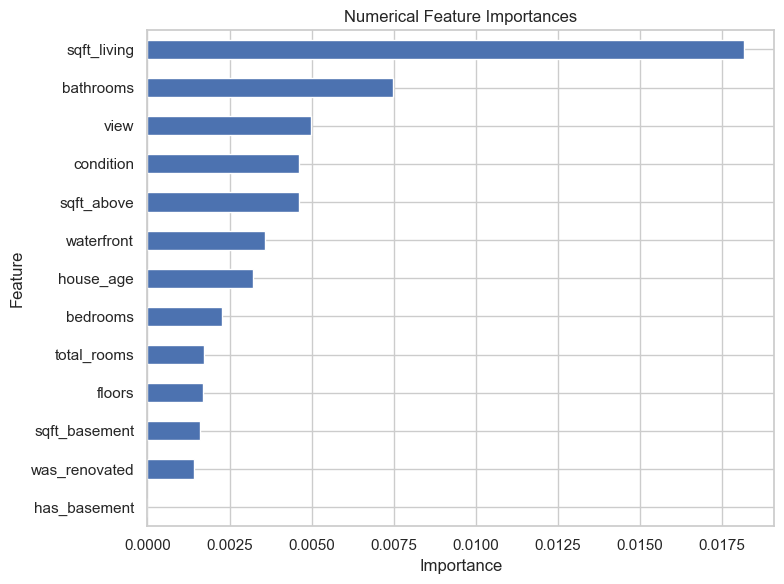

In [65]:
numeric_only = [f for f in feat_imp_full.index if f in numerical_features]
feat_imp_numeric = feat_imp_full[numeric_only].sort_values(ascending=False)

feat_imp_numeric.plot(kind='barh', figsize=(8, 6))
plt.title("Numerical Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<h3>Graph Explanation:</h3>

<p>This bar chart shows which <b>numerical features</b> contributed the most to the model’s predictions:</p>

<ul>
  <li><b>sqft_living</b> was the most influential numeric feature, representing the size of the property.</li>
  <li><b>bathrooms</b>, <b>view</b>, <b>condition</b>, and <b>sqft_above</b> followed with moderate importance.</li>
  <li>Features like <b>bedrooms</b>, <b>floors</b>, <b>total_rooms</b>, and <b>sqft_basement</b> had lower but non-zero contributions.</li>
</ul>

<h3>❓ Why these features didn’t appear in the earlier importance graph (Top 15)?</h3>

<p><b>Answer:</b></p>

<p>The earlier graph plotted only the <b>top 15 total features</b>, including both:</p>

<ul>
  <li>One-hot encoded <b>categorical features</b> (e.g., <code>city_Seattle</code>, <code>statezip_WA 98168</code>, etc.)</li>
  <li>And <b>numeric features</b></li>
</ul>

<h3>However:</h3>

<ul>
  <li>Each <b>categorical column</b> (like <code>city</code> or <code>statezip</code>) was split into <b>many  dummy variables</b> using <code>OneHotEncoder</code>.</li>
  <li>These city/statezip dummies <b>dominated the top positions</b> in the chart because there were many of them, and each had <b>slightly higher individual importance</b> than numeric features.</li>
</ul>

<h3> Meanwhile:</h3>

<ul>
  <li>Each <b>numeric feature</b> (like <code>sqft_living</code> or <code>bathrooms</code>) remained a <b>single column</b>.</li>
  <li>Even though useful, their <b>individual contribution appeared smaller</b> compared to the most important encoded categories.</li>
</ul>

<h2>Deployment</h2>

In [80]:
!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import numpy as np
import pandas as pd

# Input fields
bedrooms_input = widgets.IntSlider(value=3, min=0, max=10, description="Bedrooms")
sqft_living_input = widgets.IntText(value=1800, description="Sqft Living")
bathrooms_input = widgets.FloatSlider(value=2, min=0.5, max=5.0, step=0.25, description="Bathrooms")
floors_input = widgets.Dropdown(options=[1, 2, 3], value=1, description='Floors')
city_input = widgets.Dropdown(options=sorted(df['city'].unique()), value=sorted(df['city'].unique())[0], description='City')
zip_input = widgets.Dropdown(options=sorted(df['statezip'].unique()), value=sorted(df['statezip'].unique())[0], description='Zip')

# Display box
output = widgets.Output()

# Prediction function
def predict_price(b):
    output.clear_output()
    with output:
        try:
            test_data = pd.DataFrame({
                'sqft_living': [sqft_living_input.value],
                'bedrooms': [bedrooms_input.value],
                'bathrooms': [bathrooms_input.value],
                'floors': [floors_input.value],
                'waterfront': [0],
                'view': [0],
                'condition': [3],
                'sqft_above': [sqft_living_input.value],
                'sqft_basement': [0],
                'house_age': [2024 - 2000],  # assume built in 2000
                'was_renovated': [0],
                'has_basement': [0],
                'total_rooms': [bedrooms_input.value + bathrooms_input.value],
                'city': [city_input.value],
                'statezip': [zip_input.value]
            })

            test_transformed = preprocessor.transform(test_data)  # preprocess input
            prediction_log =best_model.predict(test_transformed)
            prediction = np.expm1(prediction_log)  # invert log1p used on target

            display(HTML(f"""
                <div style="
                    background-color:#e6f2ff;
                    padding:15px;
                    border-radius:10px;
                    font-size:18px;
                    margin-top:10px;
                    border-left:5px solid #1c84c6;">
                    💰 <b>Predicted Price:</b> <span style='color:green;'>${prediction[0]:,.2f}</span>
                </div>
            """))
        except Exception as e:
            print("Prediction failed:", str(e))

# Predict button
predict_btn = widgets.Button(description="Predict Price", button_style='success')
predict_btn.on_click(predict_price)

# Layout
display(HTML("<h3 style='color:#0f62fe;'>🏠 House Price Predictor (Test UI)</h3>"))
form = widgets.VBox([
    sqft_living_input,
    bedrooms_input,
    bathrooms_input,
    floors_input,
    city_input,
    zip_input,
    predict_btn,
    output
])
display(form)